In [4]:
!pip install patool
import patoolib
# patoolib.extract_archive("isic-2020-resized.zip")
patoolib.extract_archive("train-resized.zip")
patoolib.extract_archive("test-resized.zip")

patool: Extracting train-resized.zip ...
patool: ... train-resized.zip extracted to `train-resized'.
patool: Extracting test-resized.zip ...
patool: ... test-resized.zip extracted to `test-resized'.


'test-resized'

In [24]:
#Imports
!pip3 install tqdm
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader,Dataset,random_split,WeightedRandomSampler
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from torchvision.io import read_image
from collections import Counter

In [2]:
#create csv file for test
csv_exist=False
if not csv_exist:
    img_dir="./test-resized"
    with open('test-name.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        field = ["name"]
        writer.writerow(field)
        for x in os.listdir(img_dir):
            writer.writerow([os.path.splitext(x)[0]])
    print("Done!")

Done!


In [25]:
#Chargement des données
#Définition des classes
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+".jpg")
        image = read_image(img_path)
        #preprocess img
        image=image.float()
        image *= (1.0/image.max())
        label = self.img_labels.iloc[idx, 1]
        label=torch.tensor(float(label)) #preprocess label
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
class CustomImageTestset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_name = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_name.iloc[idx,0]+".jpg")
        image = read_image(img_path)
        image=image.float()
        image *= (1.0/image.max())
        if self.transform:
            image = self.transform(image)
        return image



Classe du dataset train+val : {0: 32542, 1: 584}
-------------------------------
Classe du dataset train : [29301   512]
-------------------------------
Taille image train : torch.Size([3, 224, 224]), Label : torch.Size([])
   ----------------------------


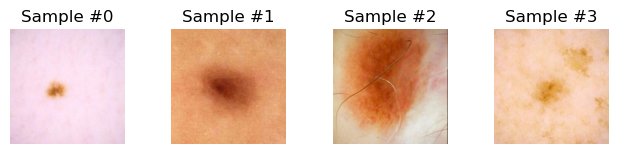

Classe du dataset de validation : {0: 3241, 1: 72}
-------------------------------
Taille image val: torch.Size([3, 224, 224]), Label : torch.Size([])
   ----------------------------


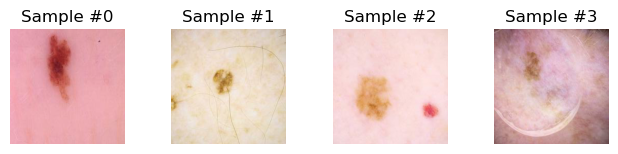

Dataset de test 
-------------------------------
Taille image test: torch.Size([3, 224, 224])
   ----------------------------


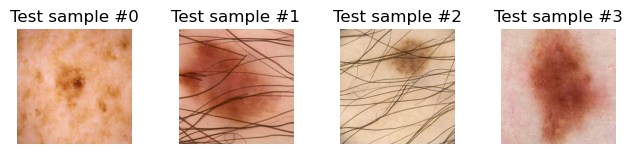

In [26]:
#Chargement des données
#Instanciation des dataloaders

dataset=CustomImageDataset(annotations_file='./train-labels.csv',img_dir='./train-resized')
generator1 = torch.Generator().manual_seed(42)
l=len(dataset)
train_dataset,val_dataset=random_split(dataset,[round(0.9*l), round(0.1*l)], generator=generator1)


test_dataset=CustomImageTestset(annotations_file='./test-name.csv',img_dir='./test-resized')
print(f"Classe du dataset train+val : {dict(Counter(dataset.img_labels.iloc[:, 1]))}\n-------------------------------")

label_train = [train_dataset.dataset.img_labels.iloc[i,1] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(label_train == t)[0]) for t in np.unique(label_train)])
print(f"Classe du dataset train : {class_sample_count}\n-------------------------------")

for i, sample in enumerate(train_dataset):
    if i == 0:
        print(f"Taille image train : {sample[0].shape}, Label : {sample[1].shape}\n   ----------------------------")
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break
print(f"Classe du dataset de validation : {dict(Counter(val_dataset.dataset.img_labels.iloc[i,1] for i in val_dataset.indices))}\n-------------------------------")
for i, sample in enumerate(val_dataset):
    if i == 0:
        print(f"Taille image val: {sample[0].shape}, Label : {sample[1].shape}\n   ----------------------------")
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break

print(f"Dataset de test \n-------------------------------")
for i, sample in enumerate(test_dataset):
    if i == 0:
        print(f"Taille image test: {sample.shape}\n   ----------------------------")
    ay = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ay.set_title('Test sample #{}'.format(i))
    ay.axis('off')
    plt.imshow(sample.T)
    if i == 3:
        plt.show()
        break

In [52]:
#Mise en forme des données

batch_size = 256

#distribue les classes dans chaque sample
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in label_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight),replacement=True)
samp=True
# Create data loaders.
if samp:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=4,sampler=sampler)
else:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=4)
val_dataloader=DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=4)

for X,y in train_dataloader:
    print(f"Classe du batch : {np.array([len(torch.where(y == t)[0]) for t in torch.unique(y)])}\n-------------------------------")
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Classe du batch : [134 122]
-------------------------------
Shape of X [N, C, H, W]: torch.Size([256, 3, 224, 224])
Shape of y: torch.Size([256]) torch.float32


In [65]:
# Création du modèle
import torchvision.models as models #import resnet18, ResNet18_Weights
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Define model
model = models.resnet18(pretrained=True)
#freeze params
for params in model.parameters():
  params.requires_grad_ = True

model= model.cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.fc = model.fc.cuda()  if device=="cuda" else net.fc
# print(model)

Using cuda device


In [66]:
#défini la fonction de perte et l'optimiseur
pos_weight=torch.tensor(class_sample_count[0]/class_sample_count[1])
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [67]:
#val
def val(model,loss_fn,val_dataloader,csv_file,loss=None,nb="Last"):
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    total_samples_0 = 0
    total_samples_1 = 0
    correct_predictions_0 = 0
    correct_predictions_1 = 0
    num_batches = len(val_dataloader)
    
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        for val_batch, (val_X, val_y) in enumerate(val_dataloader):
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_pred = model(val_X)
            val_loss += loss_fn(val_pred.squeeze(), val_y).item()
            # Calculate accuracy for each class
            predicted_labels=torch.sigmoid(val_pred.T)
            correct_predictions_0 += ((val_y == 0) & (predicted_labels < 0.5)).sum().item()
            correct_predictions_1 += ((val_y == 1) & (predicted_labels >= 0.5)).sum().item()
            total_samples_0 += (val_y == 0).sum().item()
            total_samples_1 += (val_y == 1).sum().item()
 
        accuracy_0 = correct_predictions_0 / total_samples_0
        accuracy_1 = correct_predictions_1 / total_samples_1
        accuracy_gen= (correct_predictions_0+correct_predictions_1) / (total_samples_0+total_samples_1)
        avg_val_loss = val_loss / (val_batch + 1)
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            if loss==None:
                writer.writerow([nb,round(accuracy_gen,3),round(accuracy_0,3),round(accuracy_1,3),round(avg_val_loss,3)])
            else:
                writer.writerow([nb,round(accuracy_gen,3),round(accuracy_0,3),round(accuracy_1,3),round(avg_val_loss,3),torch.round(loss,decimals=3).item()])
    
    



In [68]:
#training
epochs=10
nb_batch=len(train_dataloader)
print(f"Number of batches : {nb_batch}\n-------------------------------")
with open('val'+str(batch_size)+'.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["epoch","gen acc","acc0","acc1","val_loss","loss"]
    writer.writerow(field)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataset)
    model.train()
    for batch, (X, y) in tqdm(enumerate(train_dataloader), total=nb_batch):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
    val(model,loss_fn,val_dataloader,'val'+str(batch_size)+'.csv',loss=loss,nb=t)
        # if batch+1 % round((nb_batch-1)/3) == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        
print("Done!")


Number of batches : 117
-------------------------------
Epoch 1
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.21it/s]


Epoch 2
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Epoch 3
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Epoch 4
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Epoch 5
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Epoch 6
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Epoch 7
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Epoch 8
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Epoch 9
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Epoch 10
-------------------------------


100%|██████████| 117/117 [01:37<00:00,  1.20it/s]


Done!


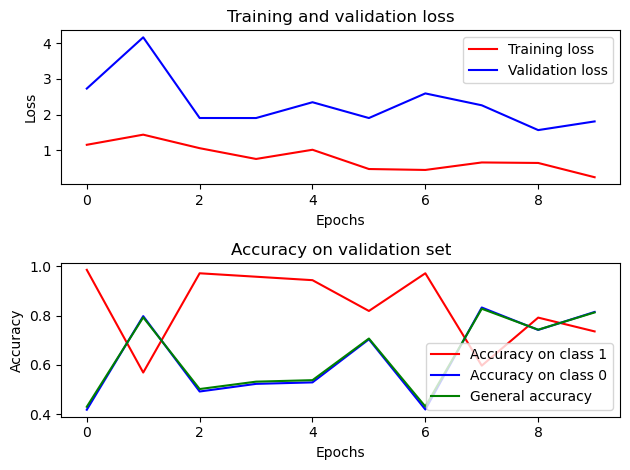

In [74]:
#Visualize data

figure, axis = plt.subplots(2, 1)
csv_file=pd.read_csv('val'+str(batch_size)+'.csv')
axis[0].plot(csv_file["epoch"], csv_file["loss"], 'r', label='Training loss')
axis[0].plot(csv_file["epoch"], csv_file["val_loss"], 'b', label='Validation loss')
axis[0].set_title('Training and validation loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(csv_file["epoch"], csv_file["acc1"], color='orange', label='Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0"], 'b', label='Accuracy on class 0')
axis[1].plot(csv_file["epoch"], csv_file["gen acc"], 'g', label='General accuracy')
axis[1].set_title('Accuracy on validation set')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()
plt.tight_layout()
plt.show()

In [23]:
#test

num_batches = len(test_dataloader)
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    with open('test'+str(batch_size)+'.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        field = ["image_name","target"]
        writer.writerow(field)
        for test_batch, test_X in tqdm(enumerate(test_dataloader)):
            test_X = test_X.to(device)
            test_pred = model(test_X)
            predicted_labels=torch.sigmoid(test_pred)
           
            for i,x in enumerate(predicted_labels) :
                # print(test_batch)
                # print(i)
                writer.writerow([test_dataloader.dataset.img_name.iloc[(batch_size*test_batch)+i, 0],round(x.item(),3)])

43it [00:14,  2.99it/s]


In [ ]:
#ancien val
val_loss = 0.0
correct_predictions = 0
total_samples = 0
total_samples_0 = 0
total_samples_1 = 0
correct_predictions_0 = 0
correct_predictions_1 = 0
size = len(val_dataset)
num_batches = len(val_dataloader)

with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    for val_batch, (val_X, val_y) in tqdm(enumerate(val_dataloader)):
        val_X, val_y = val_X.to(device), val_y.to(device)

        val_pred = model(val_X)
        val_loss += loss_fn(val_pred.squeeze(), val_y).item()
        predicted_labels=torch.sigmoid(val_pred.T)
        #_, predicted_labels = torch.max(val_pred, 1)
        # print(val_y)
        # print("aa",predicted_labels)
        correct_predictions_0 += ((val_y == 0) & (predicted_labels < 0.5)).sum().item()
        correct_predictions_1 += ((val_y == 1) & (predicted_labels >= 0.5)).sum().item()
        
        # print(((val_y == 0) & (predicted_labels < 0.5)).sum())
        # for i,x in enumerate(predicted_labels) :
            # if (val_y[i] == 0):
            #     # writer.writerow([x.item(),val_y[i].item(),(x < 0.5).item()])
            #     pass
            # else:
            #     writer.writerow([x.item(),val_y[i].item(),(x > 0.5).item()])

        # Calculate accuracy for each class
        total_samples_0 += (val_y == 0).sum().item()
        total_samples_1 += (val_y == 1).sum().item()
        # if val_batch % round(num_batches) == 0 | (predicted_labels > 0.5).sum()>0:
        #     print(f"pred: {torch.sigmoid(val_pred.T)}\n y:{val_y}")

accuracy_0 = correct_predictions_0 / total_samples_0
accuracy_1 = correct_predictions_1 / total_samples_1
accuracy_gen= (correct_predictions_0+correct_predictions_1) / (total_samples_0+total_samples_1)
avg_val_loss = val_loss / (val_batch + 1)
with open('val'+str(batch_size)+'.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["gen acc","acc0","acc1","loss"]
    writer.writerow(field)
    writer.writerow([accuracy_gen,accuracy_0,accuracy_1,avg_val_loss])
print(f"Validation loss: {avg_val_loss:.4f}    Accuracy:{accuracy_gen:.4f}")
# Display class-wise accuracy
print(f"        Accuracy for class 0: {accuracy_0:.4f}    class 1: {accuracy_1:.4f}")
print()